# Imports

In [1]:
import pandas as pd
from feature_engine.timeseries.forecasting import LagFeatures

from ForecastEvaluator import ForecastEvaluator
from _config import PKL_PROCESSED_STEP1_DTU_SOLAR_STATION

# Load (Preprocessed Step 1) DTU Solar Station data

In [2]:
df = pd.read_pickle(PKL_PROCESSED_STEP1_DTU_SOLAR_STATION)
df = df[sorted(df.columns)]
df_raw = df.copy()

print(df.shape)
print(df.info())
df.head()

(2460742, 10)
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2460742 entries, 2015-03-12 05:36:00 to 2025-01-01 08:04:00
Data columns (total 10 columns):
 #   Column             Dtype  
---  ------             -----  
 0   DHI                float64
 1   DNI                float64
 2   air_pressure       float64
 3   air_temperature    float64
 4   rain_duration      float64
 5   rain_intensity     float64
 6   relative_humidity  float64
 7   solar_altitude     float64
 8   wind_dir_avg       float64
 9   wind_speed_avg     float64
dtypes: float64(10)
memory usage: 206.5 MB
None


,DHI,DNI,air_pressure,air_temperature,rain_duration,rain_intensity,relative_humidity,solar_altitude,wind_dir_avg,wind_speed_avg
2015-03-12 05:36:00,2.890,0.000000,1028.0,0.0,0.0,0.0,81.6,0.004880,85.0,1.0
2015-03-12 05:37:00,3.128,0.000000,1028.0,0.0,0.0,0.0,81.9,0.120481,121.0,0.3
2015-03-12 05:38:00,3.307,0.814740,1028.0,0.0,0.0,0.0,81.7,0.237359,342.0,0.7
2015-03-12 05:39:00,3.657,26.392772,1028.0,0.0,0.0,0.0,81.6,0.355447,342.0,0.7
2015-03-12 05:40:00,4.056,61.929423,1028.0,0.0,0.0,0.0,81.5,0.474681,302.0,1.2


# Lag values

In [3]:
TARGET = 'DHI'
full_range = pd.date_range(start=df_raw.index.min(), end=df_raw.index.max(), freq="1min")
df = df_raw[TARGET].copy().to_frame()
df = df.reindex(full_range)
df.sort_index(inplace=True)
mask = df.isna().values
df[mask] = 0
lf = LagFeatures(periods=[60], drop_original=False, drop_na=False)
df = lf.fit_transform(df)
df = df[~mask]
df = df.dropna()
df

,DHI,DHI_lag_60
2015-03-12 06:36:00,27.93,2.890
2015-03-12 06:37:00,28.29,3.128
2015-03-12 06:38:00,28.70,3.307
2015-03-12 06:39:00,29.17,3.657
2015-03-12 06:40:00,29.48,4.056
...,...,...
2025-01-01 08:00:00,0.00,0.000
2025-01-01 08:01:00,0.00,0.000
2025-01-01 08:02:00,0.00,0.000
2025-01-01 08:03:00,0.00,0.000


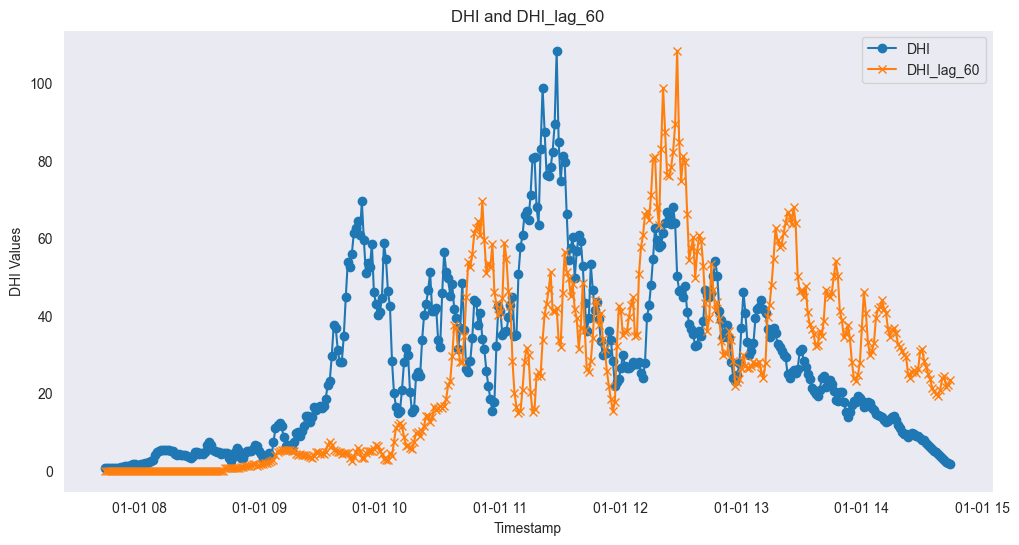

In [4]:
import matplotlib.pyplot as plt

# Select a subset of the data for plotting
subset = df.loc['2023-01-01']

# Plot the original and lagged values
plt.figure(figsize=(12, 6))
plt.plot(subset.index, subset['DHI'], label='DHI', marker='o')
plt.plot(subset.index, subset['DHI_lag_60'], label='DHI_lag_60', marker='x')
plt.title('DHI and DHI_lag_60')
plt.xlabel('Timestamp')
plt.ylabel('DHI Values')
plt.legend()
plt.grid()
plt.show()

# Datasplitting

In [27]:
train_df = df.loc[:'2020']
val_df = df.loc['2021':'2022']
test_df = df.loc['2023':]
print(train_df.shape, val_df.shape, test_df.shape)
df = test_df.copy()

(1427680, 3) (511008, 3) (521994, 3)


# Persistence model

In [28]:
test_df.to_csv('test_df.csv', index=True, header=True, sep=',')

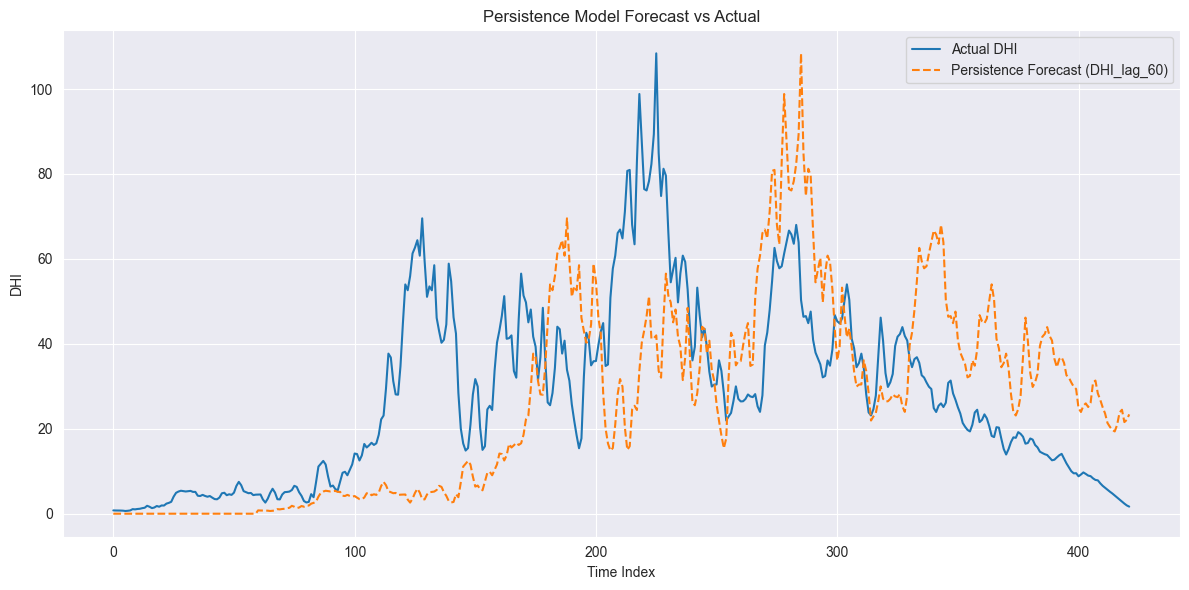

In [29]:
import matplotlib.pyplot as plt
from ForecastEvaluator import ForecastEvaluator

# Actual and predicted values
y_true = test_df['DHI']
y_pred = test_df['DHI_lag_60']

# Plot actual vs predicted
plt.figure(figsize=(12, 6))
plt.plot(y_true.loc['2023-01-01'].values, label='Actual DHI')
plt.plot(y_pred.loc['2023-01-01'].values, label='Persistence Forecast (DHI_lag_60)', linestyle='--')
plt.title('Persistence Model Forecast vs Actual')
plt.xlabel('Time Index')
plt.ylabel('DHI')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [30]:
# Calculate metrics
evaluator = ForecastEvaluator(y_true.values, y_pred.values)
display(evaluator.evaluate_all())

{'RMSE': np.float64(72.3204301664726),
 'MAE': 47.57135472675357,
 'MAPE': np.float64(106.8085629455738),
 'R2': 0.5017891781151756,
 'NMAE': np.float64(0.0547993949162004),
 'NRMSE': np.float64(0.08330887013762539),
 'Skill Score': 0.5017891781151756,
 'MBE': np.float64(-1.486882253748127)}

In [31]:
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf

# Calculate residuals
df['residual'] = df['DHI'] - df['DHI_lag_60']

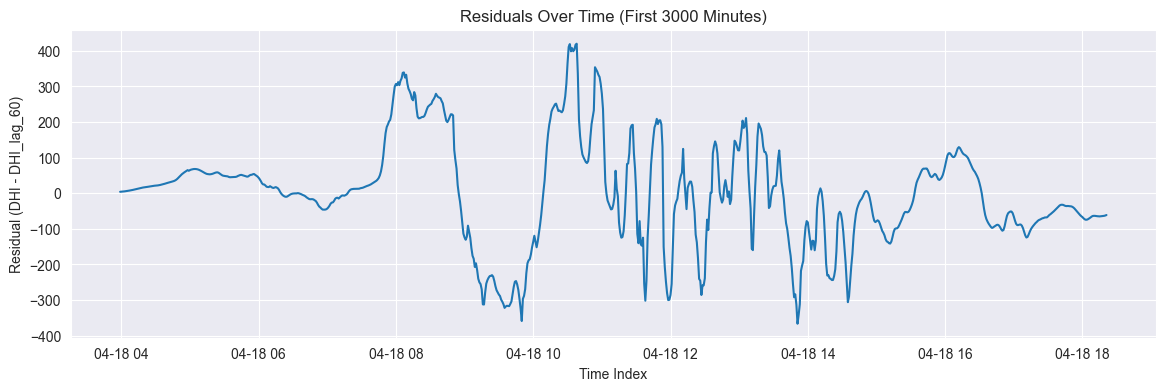

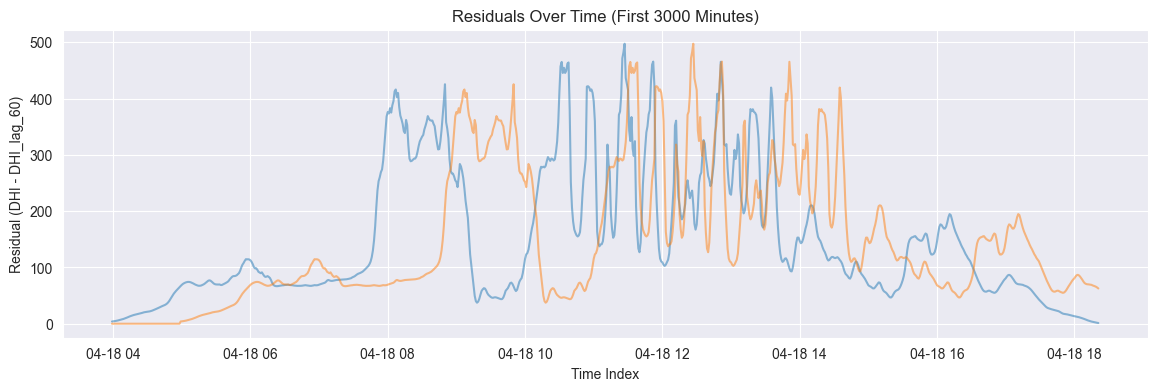

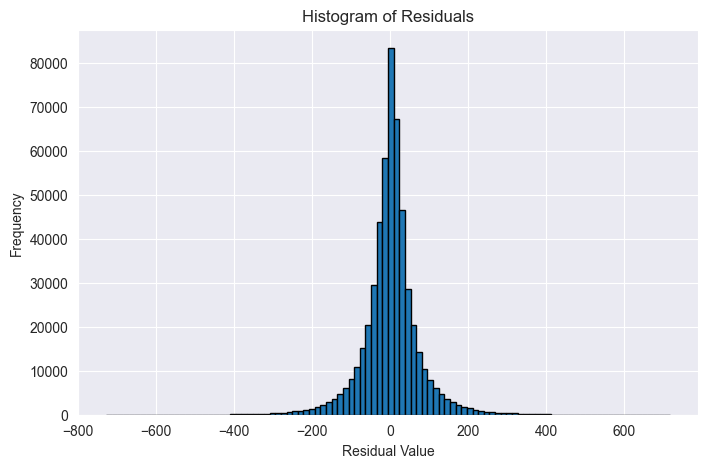

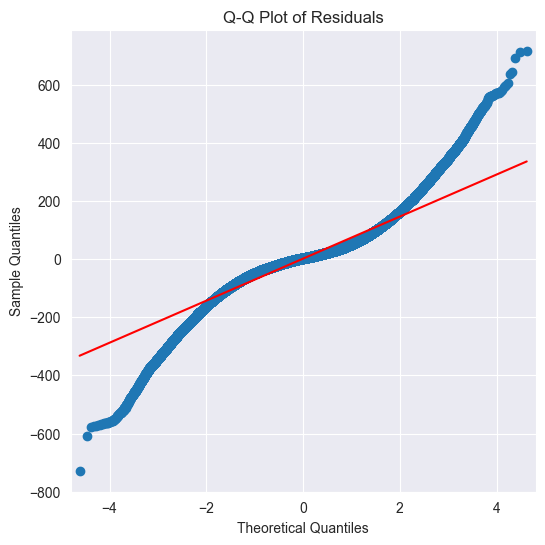

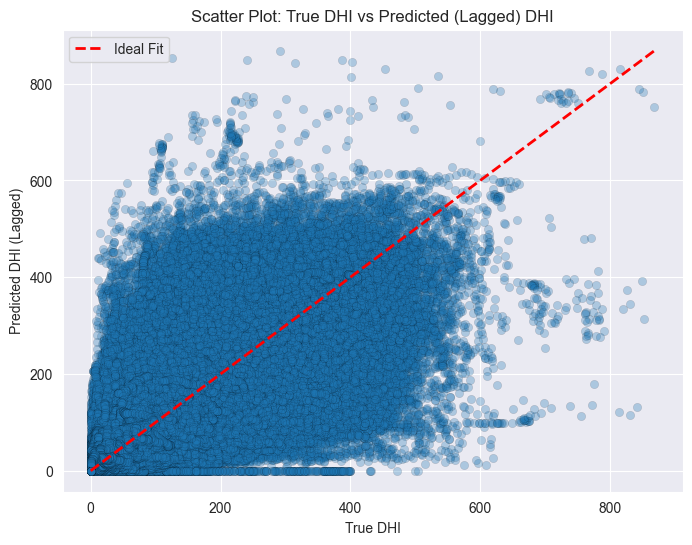

In [34]:
import random
random.seed(42)

# sample date from df
sample_date = random.choice(df.index).strftime('%Y-%m-%d')

# Plot residuals ignoring index (subset for visibility)
plt.figure(figsize=(14, 4))
# plot the first 5 days of residuals
plt.plot(df.loc[sample_date]['residual'])
plt.title("Residuals Over Time (First 3000 Minutes)")
plt.xlabel("Time Index")
plt.ylabel("Residual (DHI - DHI_lag_60)")
plt.grid(True)
plt.show()
plt.figure(figsize=(14, 4))
# plot the actual true and predicted values
plt.plot(df.loc[sample_date]['DHI'][:60*24*1], label='DHI', alpha=0.5)
plt.plot(df.loc[sample_date]['DHI_lag_60'][:60*24*1], label='DHI_lag_60', alpha=0.5)
plt.title("Residuals Over Time (First 3000 Minutes)")
plt.xlabel("Time Index")
plt.ylabel("Residual (DHI - DHI_lag_60)")
plt.grid(True)
plt.show()

# Histogram of residuals
plt.figure(figsize=(8, 5))
plt.hist(df['residual'], bins=100, edgecolor='k')
plt.title("Histogram of Residuals")
plt.xlabel("Residual Value")
plt.ylabel("Frequency")
plt.grid(True)
plt.show()

# Q-Q plot for residuals
plt.figure(figsize=(6, 6))
sm.qqplot(df['residual'].dropna(), line='s', ax=plt.gca())
plt.title("Q-Q Plot of Residuals")
plt.grid(True)
plt.show()

# Scatter plot of predicted vs actual DHI
plt.figure(figsize=(8, 6))
plt.scatter(df['DHI'], df['DHI_lag_60'], alpha=0.3, edgecolor='k', linewidth=0.2)
plt.title("Scatter Plot: True DHI vs Predicted (Lagged) DHI")
plt.xlabel("True DHI")
plt.ylabel("Predicted DHI (Lagged)")
plt.grid(True)
plt.plot([df['DHI'].min(), df['DHI'].max()],
         [df['DHI'].min(), df['DHI'].max()],
         color='red', linestyle='--', linewidth=2, label='Ideal Fit')
plt.legend()
plt.show()

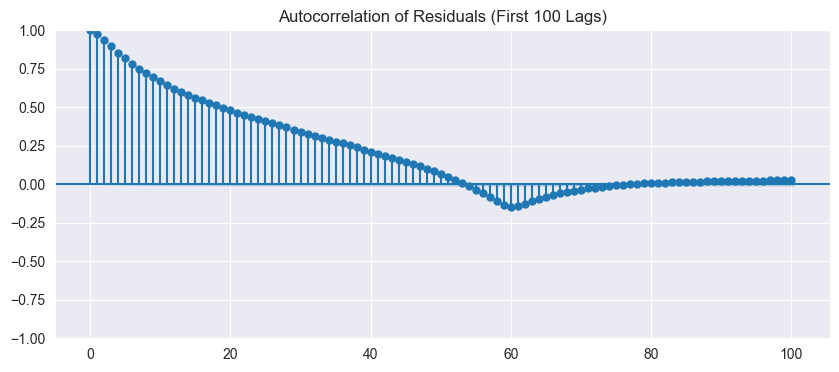

In [33]:
# Autocorrelation plot
plt.figure(figsize=(10, 4))
plot_acf(df['residual'].dropna(), lags=100, ax=plt.gca())
plt.title("Autocorrelation of Residuals (First 100 Lags)")
plt.grid(True)
plt.show()

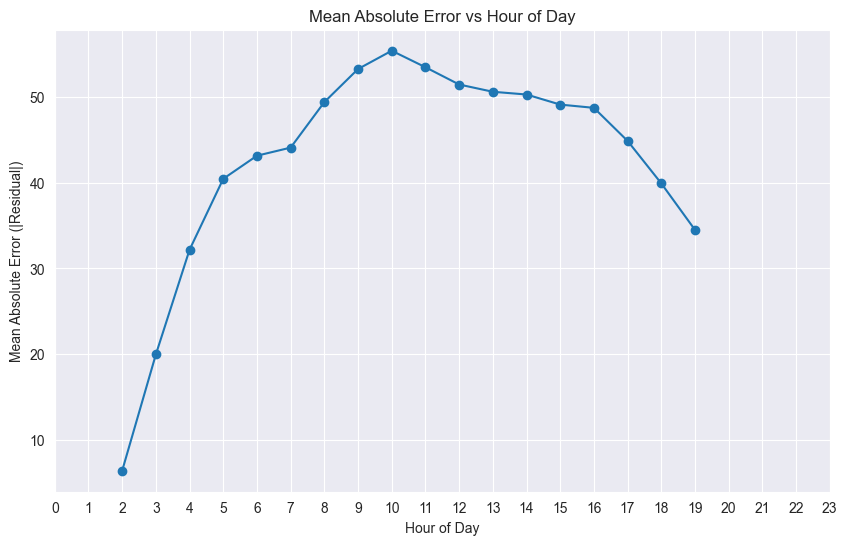

In [39]:
import numpy as np

df['hour'] = df.index.hour
df['abs_residual'] = np.abs(df['residual'])

# Group by hour and compute mean absolute residual
hourly_error = df.groupby('hour')['abs_residual'].mean()

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(hourly_error.index, hourly_error.values, marker='o')
plt.title("Mean Absolute Error vs Hour of Day")
plt.xlabel("Hour of Day")
plt.ylabel("Mean Absolute Error (|Residual|)")
plt.grid(True)
plt.xticks(range(0, 24))
plt.show()